In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_score, recall_score

In [2]:
# Switch to the directory containing training and test CSV files.
dir_path = 'C:\Users\corne\Documents\code\kaggle kick\\' #EOL "\" needs to be escaped
file_train = 'training.csv'
file_test = 'test.csv'

data = pd.read_csv(dir_path + file_train, delimiter = ",", header = 0)
y = data.pop('IsBadBuy')

# Merge training and testing data for data prep with an indicator column used to split them afterward
dataFinalTest = pd.read_csv(dir_path + file_test, delimiter = ",", header = 0)
dataFinalTest['is_final_test'] = True
data['is_final_test'] = False
data = data.append(dataFinalTest)

In [3]:
# data['BYRNO'].value_counts()

In [4]:
# Date conversion
start_date = pd.to_datetime('2009-01-01')
data['PurchDate'] = pd.to_datetime(data['PurchDate']) - start_date
data['PurchDate'] = data['PurchDate'].dt.days

In [5]:
# Deal with NAs and categorical data
types = data.dtypes
numTypes = ['int64', 'float64']
numCols = [col for col in data.columns if types[col] in numTypes]
catCols = [col for col in data.columns if types[col] not in numTypes]

data[numCols] = data[numCols].fillna(data[numCols].median())

for col in catCols:
    data[col] = pd.factorize(data[col])[0]

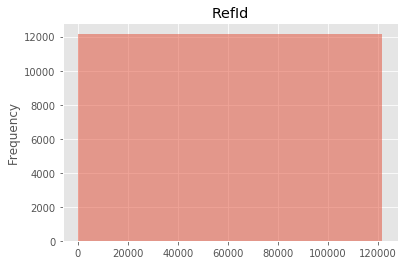

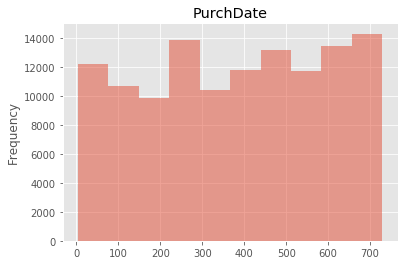

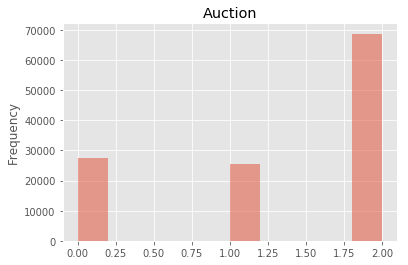

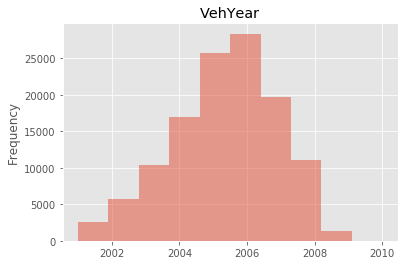

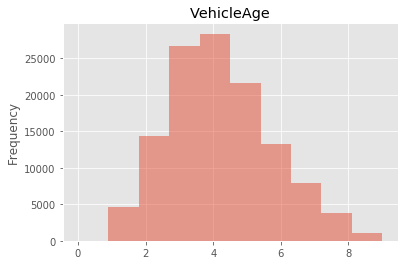

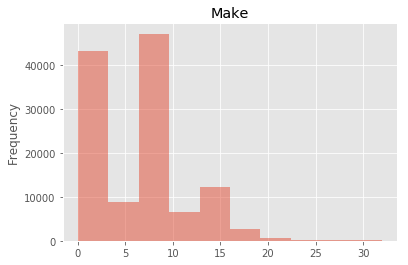

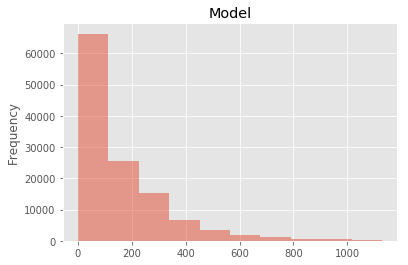

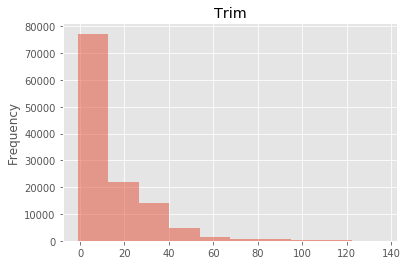

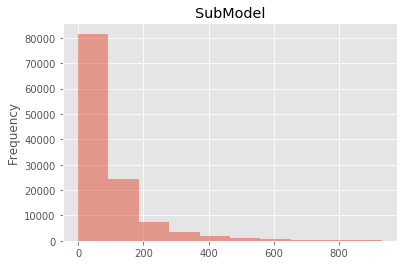

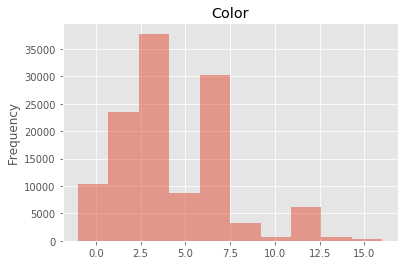

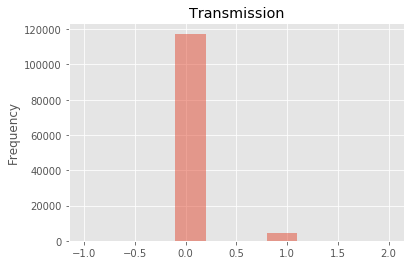

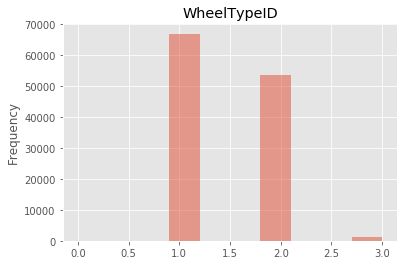

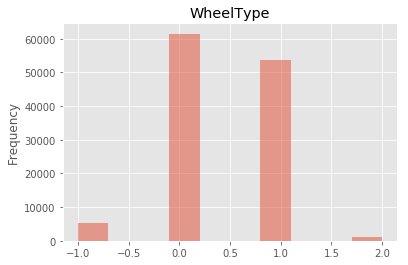

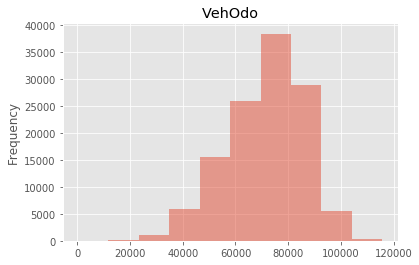

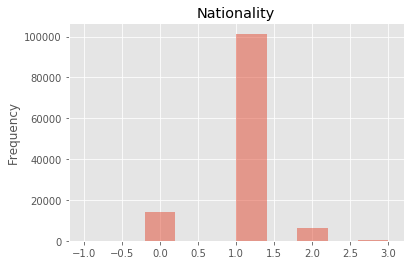

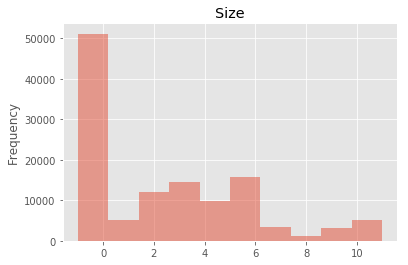

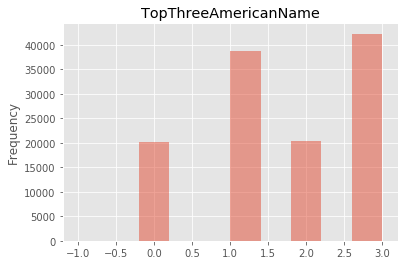

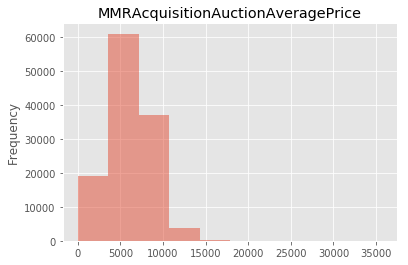

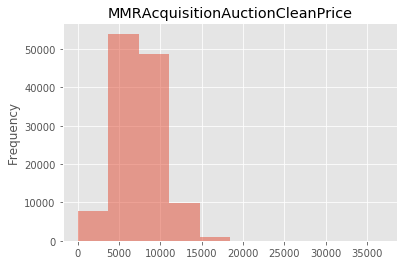

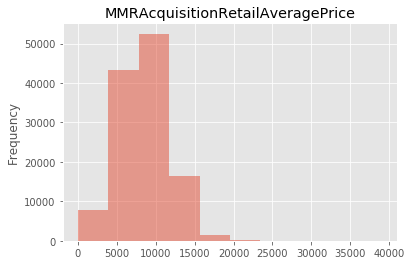

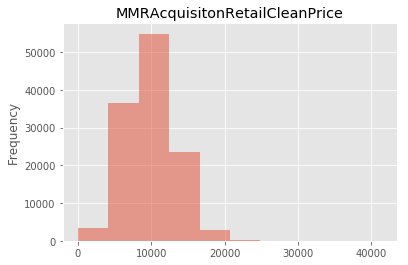

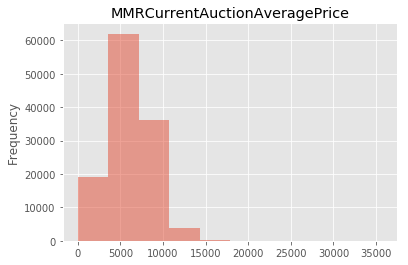

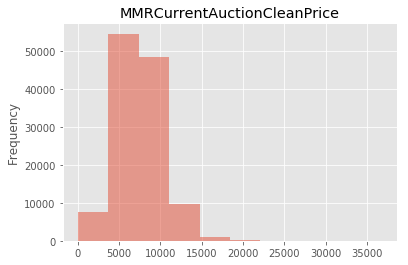

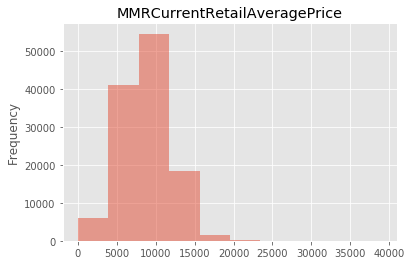

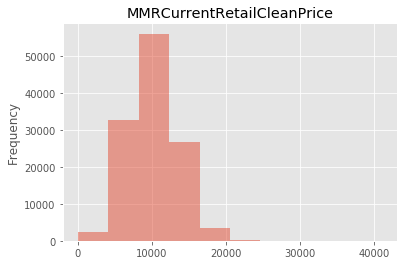

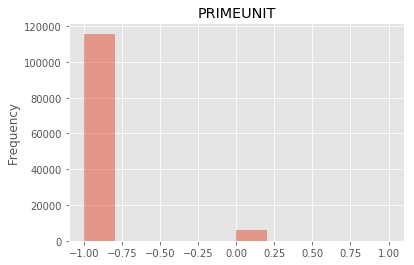

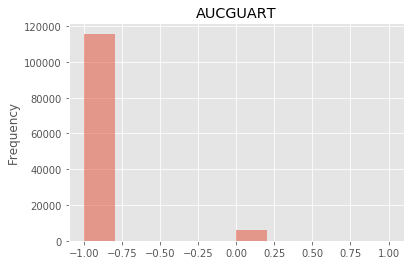

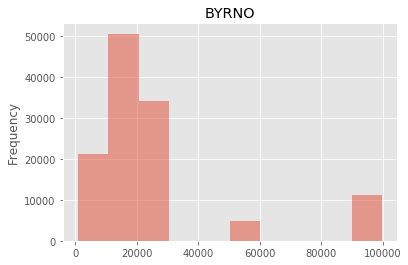

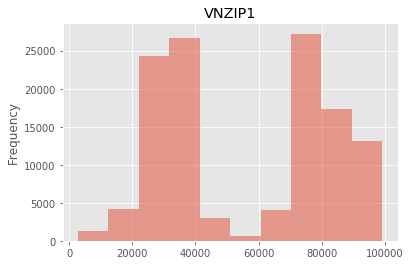

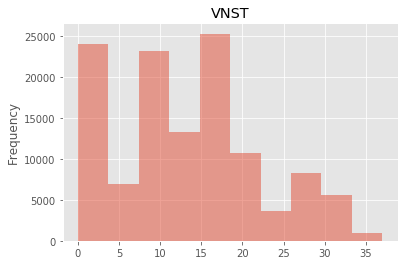

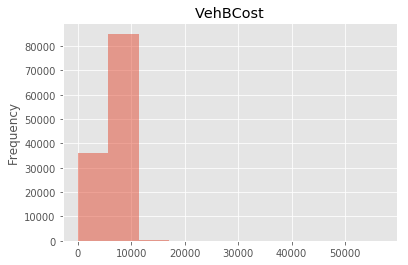

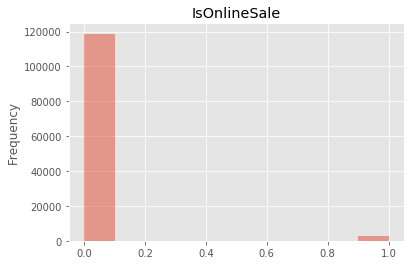

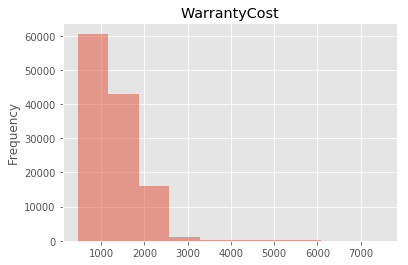

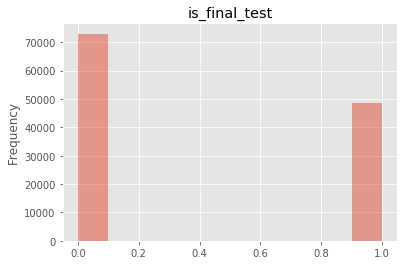

In [6]:
# plots. Commented out for speed. 
matplotlib.style.use('ggplot')

# for col in data.columns:
#     plt.title(col)
#     data[col].plot.hist(alpha=0.5)
#     plt.show()

In [7]:
# Scale numeric data
for col in numCols[1:]:
    tmp = data[col].values.astype(float)
    scaler = MinMaxScaler()
    tmp = scaler.fit_transform(tmp.reshape(-1, 1))[:,0]
    data[col] = tmp

In [8]:
# Separate training data from final test data
data, dataFinalTest = data[data['is_final_test'] == False], data[data['is_final_test'] == True]

In [9]:
# 10-fold cross-validation
np.random.seed(0)
data['is_train'] = np.random.randint(10, size = len(data))

recallScores = []
precisionScores = []

for i in xrange(10):
    # data['is_train'] = np.random.uniform(0, 1, len(data)) <= .75
    # train, test = data[data['is_train']==True], data[data['is_train']==False]
    train, test = data[data['is_train']!=i], data[data['is_train']==i]
    yTrain = y[data['is_train']!=i]
    yTest = y[data['is_train']==i]

    #create and train the classifier

    clf = RandomForestClassifier(n_jobs=2, random_state=0)

    colsToUse = data.columns
    colsToUse = colsToUse.drop(['RefId','is_train', 'is_final_test'])
    clf.fit(train[colsToUse], yTrain)
    preds = clf.predict(test[colsToUse])
    recallScores.append(recall_score(yTest, preds))
    precisionScores.append(precision_score(yTest, preds))
#     print i
#     print len(train)
#     print pd.crosstab(yTest, preds, rownames = ['Actual Class'], colnames=['Predicted Class'])
#     print classification_report(yTest, preds) # <--- PRINT THIS if interested in reports on folds

In [10]:
f1socres = [2*p*r/(p+r) for p,r in zip(precisionScores, recallScores)]
print 'Precision by fold:', ["%0.2f" % i for i in precisionScores], 'Mean precision:', "%0.2f" % np.mean(precisionScores)
print 'Recall by fold:   ', ["%0.2f" % i for i in recallScores], 'Mean recall:   ', "%0.2f" % np.mean(recallScores)
print 'F1 score by fold: ', ["%0.2f" % i for i in f1socres], 'Mean F1 score: ', "%0.2f" % np.mean(f1socres)

Precision by fold: ['0.82', '0.70', '0.71', '0.75', '0.74', '0.80', '0.78', '0.78', '0.76', '0.80'] Mean precision: 0.76
Recall by fold:    ['0.23', '0.21', '0.21', '0.26', '0.22', '0.24', '0.25', '0.25', '0.24', '0.24'] Mean recall:    0.24
F1 score by fold:  ['0.36', '0.33', '0.33', '0.39', '0.34', '0.37', '0.38', '0.37', '0.36', '0.37'] Mean F1 score:  0.36


In [11]:
# Model the entire training set and predict results for the final test set
clf = RandomForestClassifier(n_jobs=2, random_state=0)

colsToUse = data.columns
colsToUse = colsToUse.drop(['RefId','is_train', 'is_final_test'])
clf.fit(data[colsToUse], y)
preds = clf.predict(dataFinalTest[colsToUse])


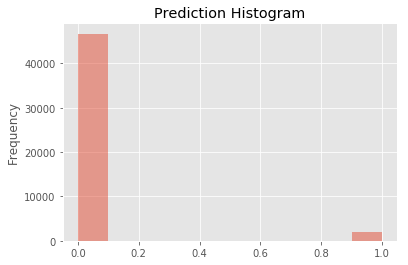

In [12]:
# histogram of predictions
np.bincount(map(lambda x: int(x), preds))
plt.title('Prediction Histogram')
predsDF = pd.DataFrame(preds, columns = ['IsBadBuy'])
predsDF['IsBadBuy'].plot.hist(alpha=0.5)
plt.show()

In [13]:
# saving the results
predsDF['RefId'] = dataFinalTest['RefId']
file_out = 'kick_results.csv'
predsDF.to_csv(dir_path + file_out, sep=',', index = False, columns = ['RefId', 'IsBadBuy'])